# Optimal control transport of trapped ions 
Transport of trapped ions is a key tool in trapped ion experiments. The task of moving one ion from A to B in the trap can be split into a series of interconnected optimization problems.

Reference: Optimal control transport of neutral atoms in optical tweezers at finite temperature, 
https://doi.org/10.1103/PhysRevResearch.6.033282

1. Reproduce the optimal control transport task discussed in the paper for the case of trapped ions. Formulate the problem as the 1D transport of one particle in a harmonic potential (rather than gaussian) and find a trajectory with minimal excitation using realistic trap parameters. You can use the python package referenced in the paper https://pypi.org/project/quocs-lib/ <br>
Bonus: transport two ions, use two control parameters (position and trap frequency), and minimize the excitation of both the COM and STR mode. 
2. Implement the transport in a realistic ion trap. Build an electrostatic model for a surface electrode trap, and find the voltage waveforms that reproduce the optimal control trajectory. I suggest using the python package pytrans https://pypi.org/project/pytrans/ (and related 
examples) 

By the due date please submit the presentation and the code. The final presentation will be 20 minutes long and you have to present the problem, methods and results. A final question on the program of the Quantum Information and Computing course will conclude the exam.

**Import zone**

In [3]:
import numpy as np
import debugger as db
import auxiliary_functions as aux
import matplotlib.pyplot as plt

In [13]:
# ===========================================================================================================
# PARAM CLASS
# ===========================================================================================================

class Param:
  """
  Param: 
    Container for holding all simulation parameters.
  """
  def __init__(self,
               x_min: float,
               x_max: float,
               num_x: int,
               tsim: float,
               num_t: int,
               im_time: bool = False) -> None:
    """
    __init__ : 
      Initialize simulation parameters.

    Parameters
    ----------
    x_min : float
      Minimum spatial value.
    x_max : float
      Maximum spatial value.
    num_x : int
      Number of spatial grid points.
    tsim : float
      Total simulation time.
    num_t : int
      Number of time steps.
    im_time : bool, optional
      Whether to use imaginary time evolution. Default is False.
    """
    # Initialization
    self.x_min = x_min
    self.x_max = x_max
    self.num_x = num_x
    self.tsim = tsim
    self.num_t = num_t
    self.im_time = im_time

    # Infinitesimal quantities (space, time, momentum)
    self.dx = (x_max - x_min) / num_x
    self.dt = tsim / num_t
    self.dk = 2 * np.pi / (x_max - x_min)

    # Spatial grid
    self.x = np.linspace(x_min + 0.5 * self.dx, x_max - 0.5 * self.dx, num_x)

    # Momentum grid -> For FFT, frequencies are in this order
    self.k = np.fft.fftfreq(num_x, d=self.dx) * 2 * np.pi

    # validation check
    self._validate()

  def _validate(self) -> None:
    """
    _validate :
      Check for common errors in parameter initialization.
    """
    if self.num_x <= 0 or self.num_t <= 0:
      db.checkpoint(debug=True, msg1="INITIALIZATION", msg2="ValueError: num_x and num_t must be positive integers.", stop=True)
    if self.x_max <= 0 or self.tsim <= 0:
      db.checkpoint(debug=True, msg1="INITIALIZATION", msg2="ValueError: xmax and tsim must be positive values.", stop=True)
      
      
# ===========================================================================================================
# OPERATORS CLASS
# ===========================================================================================================

class Operators:
  """
  Container for holding operators and wavefunction coefficients.
  """
  def __init__(self, 
               res: int, 
               voffset: float = 0,
               wfcoffset: float = 0,
               omega: float = 1.0,
               order: int = 2,
               n_max: int = 1,
               r_func=None, 
               par: Param = None,
               T = 10e-6) -> None:
    """
    __init__: 
      Initialize operator arrays and configure time-dependent potential 
      and wavefunction.

    Parameters
    ----------
    res : int
      Resolution of the spatial domain (number of grid point).
    voffset : float, optional
      Offset of the quadratic potential in real space. Default is 0.
    wfcoffset : float, optional
      Offset of the wavefunction in real space. Default is 0.
    omega : float
      Angular frequency of the harmonic oscillator. Default is 1.0.
    order : int
      Order of the finite difference approximation. Default is 2.
    n_max : int, optional
      Maximum order of the Hermite polynomial. Default is 0.
    r_func : callable, optional
      A function r_func(t) defining the time-dependent offset r(t). 
      Default is None.
    par : Param, optional
      Instance of the Param class containing simulation parameters, 
      used to initialize grid-related quantities. Default is None.
    """
    # Initialize empty complex arrays for potential, propagators, and wavefunction
    self.V = np.empty(res, dtype=complex)  # Potential operator
    self.R = np.empty(res, dtype=complex)  # Real-space propagator
    self.K = np.empty(res, dtype=complex)  # Momentum-space propagator
    self.wfcs = np.empty((n_max, res), dtype=complex)  # Wavefunction coefficients
    
    # Store finite temperature
    self.T = T

    # Energy list (finite temperature case)
    self.energies = []
    self.rho = []
    
    # Store time-dependent offset function (default to no potential if None)
    self.r_func = r_func or (lambda t: 0)
    
    # Store angular frequency
    self.omega = omega
    
    # Store maximum order of the Hermite polynomial
    self.n_max = n_max

    # Initialize potential and wavefunction if a Param instance is provided
    if par is not None:
      self._initialize_operators(par, voffset, wfcoffset, order, n_max)
      self._calculate_energy(par)
      self._density_matrix()

  def _initialize_operators(self, par: Param, voffset: float, wfcoffset: float, order: int, n_max: int) -> None:
    """
    _initialize_operators: 
      Initialize operators and wavefunction based on the provided parameters.

    Parameters
    ----------
    par : Param
      Simulation parameter instance containing grid and time information.
    voffset : float
      Offset of the quadratic potential in real space.
    wfcoffset : float
      Offset of the wavefunction in real space.
    order: int
      Order of the finite difference approximation
    n_max : int
      Maximum order of the Hermite polynomial.
      
    Returns
    -----------
    None (acts in place).
    """
    # Initial time-dependent offset (at t=0)
    r0 = self.r_func(0)

    # Quadratic potential with offset
    self.V = 0.5 * (par.x - voffset - r0) ** 2 * self.omega **2

    # Wavefunction based on a harmonic oscillator eigenstate
    #self.wfc = aux.harmonic_oscillator_spectrum(par.x - wfcoffset, self.omega, order, n).astype(complex)
    self.wfcs = self._generate_wavefunctions(par, wfcoffset, order)

    # Coefficient for imaginary or real time evolution
    coeff = 1 if par.im_time else 1j

    # Momentum and real-space propagators
    self.K = np.exp(-0.5 * (par.k ** 2) * par.dt * coeff)
    self.R = np.exp(-0.5 * self.V * par.dt * coeff)

  def _generate_wavefunctions(self, par, wfcoffset, order):
    """Generate wavefunctions up to order n_max."""
    wavefunctions = []
    for n in range(self.n_max + 1):
      wfc = aux.harmonic_oscillator_spectrum(par.x - wfcoffset, self.omega, order, n)
      wavefunctions.append(wfc)
    return np.array(wavefunctions).T

  def get_wavefunction(self, n):
    """Retrieve the nth wavefunction."""
    if n > self.n_max:
      raise ValueError(f"Requested wavefunction n={n} exceeds n_max={self.n_max}")
    return self.wavefunctions[:, n]


  def _calculate_energy(self, par: Param) -> float:
    """
    calculate_energy:
      Calculate the energy <Psi|H|Psi>.

    Parameters
    ----------
    par : Param
      Parameters of the simulation.

    Returns
    -------
    None (acts in place).
    """    
    for wfc in self.wfcs.T:
      # Creating momentum and conjugate wavefunctions.
      wfc_k = np.fft.fft(wfc)
      wfc_c = np.conj(wfc)

      # Finding the momentum and real-space energy terms
      energy_k = 0.5 * wfc_c * np.fft.ifft((par.k ** 2) * wfc_k)
      energy_r = wfc_c * self.V * wfc

      # Integrating over all space (discrete sum weighted by grid spacing)
      energy_final = (sum(energy_k + energy_r).real) * par.dx

      # Store the energy in the history  
      self.energies.append(energy_final)
      
  def _density_matrix(self):
    p = [np.exp(-self.energies[i] / self.T) for i in range(self.n_max + 1)]
    p /= np.sum(p)
    rho = 0
    
    for i in range(self.n_max + 1):
      rho += p[i] * np.outer(self.wfcs[i], self.wfcs[i])
      
    self.rho = rho

# ===========================================================================================================
    
def split_op(par: Param, opr: Operators) -> tuple:
  """
  split_op:
    Split operator method for time evolution for multiple wavefunctions.

  Parameters
  ----------
  par : Param
    Parameters of the simulation.
  opr : Operators
    Operators of the simulation.

  Returns
  -------
  densities, potential, avg_position: tuple of np.ndarray
    3D arrays containing results for all `n_max` wavefunctions:
      - densities: Shape (n_max, 100, 2 * num_x)
      - potential: Shape (n_max, 100, num_x)
      - avg_position: Shape (n_max, 100)
  """
  # Initialize 3D storage arrays
  densities = np.zeros((opr.n_max, 100, 2 * par.num_x))
  potential = np.zeros((opr.n_max, 100, par.num_x))
  avg_position = np.zeros((opr.n_max, 100))

  # Loop over all wavefunctions (columns in opr.wfcs)
  for n in range(opr.n_max):
    opr.wfc = opr.wfcs[:, n]  # Extract the nth wavefunction

    # Initialize jj for gif visualization
    jj = 0

    # Loop over the number of timesteps
    for i in range(par.num_t):
      # Update the time-dependent potential V(x, t)
      rt = opr.r_func(i * par.dt)
      opr.V = 0.5 * (par.x - rt) ** 2 * opr.omega ** 2

      # Update the real space propagator
      coeff = 1 if par.im_time else 1j
      opr.R = np.exp(-0.5 * opr.V * par.dt * coeff)

      # Half-step in real space
      opr.wfc *= opr.R

      # Full step momentum space
      opr.wfc = np.fft.fft(opr.wfc)
      opr.wfc *= opr.K
      opr.wfc = np.fft.ifft(opr.wfc)

      # Final half-step in real space
      opr.wfc *= opr.R

      # Density for plotting and potential
      density = np.abs(opr.wfc) ** 2

      # Renormalization
      if par.im_time:
        renorm_factor = np.sum(density * par.dx)
        if renorm_factor != 0.0:
          opr.wfc /= np.sqrt(renorm_factor)
          density = np.abs(opr.wfc) ** 2
        else:
          db.checkpoint(debug=True, msg1=f"RENORMALIZATION WARNING! Renorm factor too small at timestep {i}: {renorm_factor}", stop=False)

      # Saves exactly 100 snapshots
      if i % (par.num_t // 100) == 0 and jj < 100:
        # Save wfc in real and momentum space
        densities[n, jj, 0:par.num_x] = np.real(density)
        densities[n, jj, par.num_x:2 * par.num_x] = np.abs(np.fft.fft(opr.wfc)) ** 2

        # Save potential
        potential[n, jj, :] = opr.V

        # Save average position
        avg_position[n, jj] = np.sum(par.x * density) * par.dx

        # Update jj
        jj += 1

  return densities, potential, avg_position


# ===========================================================================================================
# VISUALIZATION
# ===========================================================================================================

def plot_average_position(par, avg_position):
  """
  plot_average_position :
    Plot the average position of the particle over time.

  Parameters
  ----------
  par : Param
    Parameters of the simulation.
  avg_position : np.ndarray
    Array of average position values.

  Returns
  -------
  None
  """
  # Compute time array (100 elements)
  time = np.linspace(0, par.tsim, 100)
  
  # Plot
  plt.figure(figsize=(8, 6))
  plt.plot(time, avg_position, label="Average position $\langle x(t) \\rangle$")
  plt.xlabel("Time (t)")
  plt.ylabel("Position (x)")
  plt.title("Average position of the particle over time")

  # Show
  plt.legend()
  plt.grid(True)
  plt.show()

In [14]:
# SIMULATION PARAMETERS

xmin = -5.0
xmax = 5.0
num_x = 4000
tsim = 100
desired_dt = 0.01
num_t = int(tsim/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
voffset = 0.0
wfcoffset = 0.0
omega = 1.0
order = 8
n_max = 5
T = 10
r_func = lambda t: t / tsim 

# Initialize the Operators object
opr = Operators(res, voffset, wfcoffset, omega, order, n_max, r_func, par, T)

In [15]:
opr.rho.shape

(6, 6)

In [20]:
# Thermal state with T = 10 muK 
# I need to build the density matrix depending on T

# FIX ENERGY CALCULATION FOR DIFFERENT N, then proceed
# After build r_J(t)
# Then, understand optimization

In [18]:
print(f"The final energy of the systems is: {opr.energy_history[-1]}")

The final energy of the systems is: [ 9.41657859e-07 -4.44796557e-07  2.90339041e-07 ...  2.90339041e-07
 -4.44796557e-07  9.41657859e-07]


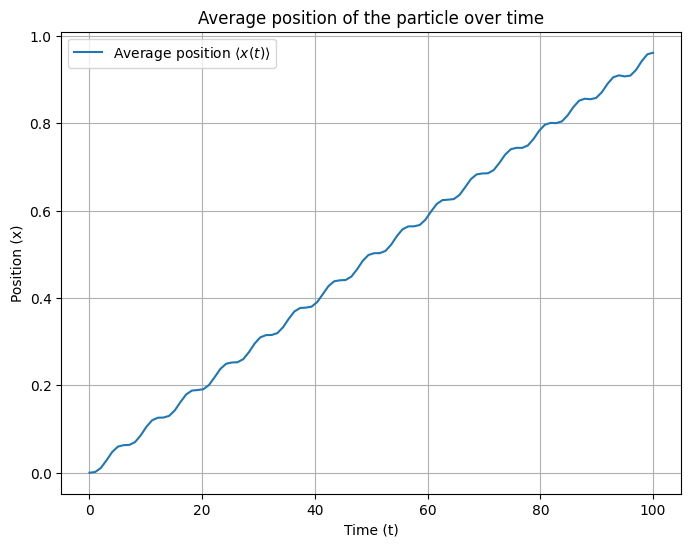

In [5]:
# Run the simulation and get the results
density, potential, avg_position = split_op(par, opr)

plot_average_position(par, avg_position)